# Assignment 3

This assignment is to predict housing prices. We're using a dataset from Ames, Iowa ([paper](http://jse.amstat.org/v19n3/decock.pdf), [dataset](http://jse.amstat.org/v19n3/decock/AmesHousing.txt)).

You may find it useful to start with the [Chollet notebook](https://colab.research.google.com/github/nrhodes/cs152fa2019/blob/master/Lecture_12_3_7_predicting_house_prices_(tf_2_0).ipynb) that does regression on Boston housing prices.

This notebook currently loads in the Ames housing dataset into a [Pandas](https://pandas.pydata.org/) dataframe ([Pandas cheatsheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)). Pandas is a Python library suited for working with large amounts of tabular data.

Your goal is to train a Neural Network to a low Mean Absolute Error on your validation dataset (that is, you want to minimize the average error in predicted house price).  Since the number of samples is fairly small, I recommend using some form of K-fold cross-validation. 

In order to ensure that the K-fold cross-validation error is accurate, ensure that you don't make the mistake that the Chollet notebook does of doing a one-time normalization of the data  and then splitting it up into training and validation.  Instead, when you do normalization, it should be based on the mean and standard deviation of *only* the data the model is being trained on (otherwise, information from the validation data has *leaked* to the training data).

You'll need to decide:
*  The structure of the Neural Network (number of layers and sizes)
*  The number of epochs
*  The choice of _k_ for k-fold validation
*  The optimizer to use
*  The activation functions to use
* The value of hyperparameters
*  Whether you want to remove uniquely-identifying information from the training instances (e.g., each training instance has a unique _Order_ and _PID_ field)
*  How you want to deal with categorical information ( [this article](https://pbpython.com/categorical-encoding.html) gives some possibilities).
*  Whether you want to create any new columns (based on existing columns)
* Whether you want to remove any columns
* Whether you want to add any regularization


Please keep a log in your notebook, keeping track of what you've tried and what its results are.

I'll be grading this assignment on:
*  Whether you've fixed the leaking validation error (w.r.t. normalization).
*  The effort/creativity you've shown in attempting to create a good model (as shown in the log).
*  The MAE you've achieved on the validation data.
* How clear your notebook is. Don't just have code cells, have text cells that describe what's going on. However, don't just copy the text cells from the Aggarwal notebook.

I expect that you'll spend between 10 and 20 hours on this assignment.


## Initialization
Ensure we're using TensorFlow 2.0.

In [ ]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
!pip install gast==0.2.2  # downgrade to resolve a proble with tf and gast 0.3
import tensorflow as tf 
print(tf.__version__)
print(tf.keras.__version__)

TensorFlow 2.x selected.
2.0.0
2.2.4-tf


Setup numpy and pandas for use.  Standard usage is to use `np` for numpy and `pd` for pandas.

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(829)

## Loading the dataset
This reads from the Ames housing tab-separated file into a pandas dataframe.

In [ ]:
df = pd.read_csv("http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


We'll make one change to the data. We'll remove a handful of outliers with total indoor square footage > 4000. I don't care about predicting those mansions in Ames, Iowa.

In [ ]:
df = df[df['1st Flr SF'] + df['2nd Flr SF'] <= 4000]

Let's look at the data:

In [ ]:
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,...,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,...,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,...,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,

As you can see, we have 2925 total samples and 82 columns of data (including the sales prices, which is what we will be trying to predict). The 82 columns are described at [the Ames Housing Data Documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

As you can see, some of the columns (like `Year Built`) are numeric, whereas others (like `House Style`) are strings. You can't feed strings directly into a Neural Network.  The `extract_data` function below drops all string-columns. See [the docs for DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html). However, at some point, you'll want to add code to encode these strings values as numbers so that the neural network can use that data.

# Preparing training and test datasets
Break apart into training and test set.  Remember that you should only ever use the test set **one time**, at the very end to determine your final accuracy.  Don't change your model and then retest the test set accuracy!

In [ ]:
mask = np.random.rand(len(df)) < 0.85

train_df = df[mask]
test_df = df[~mask]

In [ ]:
def extract_data_labels(df):
  labels = df['SalePrice'].values
  df_without_string_columns_or_sale_price = df.copy().drop(columns=['SalePrice']).select_dtypes(exclude=['object'])
  data = df_without_string_columns_or_sale_price.values.astype('float64')
  return (data, labels)

(train_data, train_targets) = extract_data_labels(train_df)
(test_data, test_targets) = extract_data_labels(test_df)

In [ ]:
train_data.shape

(2472, 38)

In [ ]:
test_data.shape

(453, 38)

As you can see, we have 2472 training samples and 453 test samples. The data comprises 38 features (the original 82 columns minus the target column and minus the string columns).

In [ ]:
train_targets

array([215000, 105000, 172000, ..., 132000, 170000, 188000])

## Hints
### Specifying non-default hyper-parameters for optimizers
When we've used optimizers so far, we've specificed the optimizer as a string (like `'adam'`), which instantiates the optimizer with all-default values:
```
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
```


In order to specificy the hyper-parameters explicitly for an optimizer, you'll need to instantiate it with desired hyper-parameters, and then pass that instantiated optimizer to the compile method:
```
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='mse', metrics=['mae'])
```



### Normalization
If it's good to normalize the inputs, does it also make sense to normalize the output?

# Submit instructions

Due date: October 28, 2019, 1 PM.

1. Before submitting, calculate (and print) the Mean Absolute Error on the test set. This'll give the best estimate of how well the model will generalize:
   `test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)`.  
   Don't do this calculation until you're ready to submit!  That is, you should only ever calculate this *one time*.
2. Make sure that the output of all cells is up-to-date (do a _Runtime/Run all_). 
1. Duplicate your notebook:
    1. Choose _File/Save a Copy in Drive…_
    1. Rename the new copy:
        1. Click on notebook name at the top of the window.
        2. Rename to "CS152Sp19Assign3 _FirstName_ _LastInitial_" (using the correct assignment number, along with your first name, and your last initial). I need this naming so I can easily navigate through the large number of shared docs I'll have by the end of the semester.
2. Share your document with me:
    1. Click on the _Share_ button at the top-right of your notebook.
    1. Enter `rhodes@g.hmc.edu` as the email address.
    1. Click the pencil icon and select _Can  edit. 
    1. Click on _Done_.
3. Don't edit the file after the submission deadline! (Feel free to make as many changes as you'd like before then, though.)
4. I'll provide inline comments when I grade the submission.


# Solution:




## Step one: Make Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

def make_model():
    model = models.Sequential()
    model.add(layers.Dense(train_data.shape[1], activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(train_data.shape[1]//2, activation='relu'))
    model.add(layers.Dense(train_data.shape[1]//4, activation='relu'))
    model.add(layers.Dense(train_data.shape[1]//8, activation='relu'))
    #model.add(layers.Dense(train_data.shape[1]//10, activation='relu'))
    model.add(layers.Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

## Step two: Use catagroical variables & remove order of houses

Frist, clean the data to represent the most important features 

In [ ]:
df = pd.read_csv("http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep=None)
df = df[df['1st Flr SF'] + df['2nd Flr SF'] <= 4000]


df['Misc Feature'] = df['Misc Feature'].replace({np.nan: 'No misc. features'})
df['Alley'] = df['Alley'].replace({np.nan: 'No alley'})
df['Fence'] = df['Fence'].replace({np.nan: 'No fence'})
df['Fireplace Qu'] = df['Fireplace Qu'].replace({np.nan: 'No fireplace'})
df['Garage Finish'] = df['Garage Finish'].replace({np.nan: 'No garage'})
df['Garage Cond'] = df['Garage Cond'].replace({np.nan: 'No garage'})
df['Garage Qual'] = df['Garage Qual'].replace({np.nan: 'No garage'})
df['Garage Type'] = df['Garage Type'].replace({np.nan: 'No garage'})
df['Bsmt Cond'] = df['Bsmt Cond'].replace({np.nan: 'No basement'})
df['Bsmt Exposure'] = df['Bsmt Exposure'].replace({np.nan: 'No basement'})
df['Bsmt Qual'] = df['Bsmt Qual'].replace({np.nan: 'No basement'})
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].replace({np.nan: 'No basement'})
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].replace({np.nan: 'No basement'})
df['Mas Vnr Type'] = df['Mas Vnr Type'].replace({np.nan: 'No masonry'})

df['Exter Qual'] = pd.Categorical(df['Exter Qual'], ordered=True, categories=['Fa','TA','Gd','Ex'])
df['Exter Cond'] = pd.Categorical(df['Exter Cond'], ordered=True, categories=['Po','Fa','TA','Gd','Ex'])
df['Bsmt Qual'] = pd.Categorical(df['Bsmt Qual'], ordered=True, categories=['No basement','Fa','TA','Gd','Ex'])
df['Bsmt Cond'] = pd.Categorical(df['Bsmt Cond'], ordered=True, categories=['No basement','Po','Fa','TA','Gd'])
df['Heating QC'] = pd.Categorical(df['Heating QC'], ordered=True, categories=['Po','Fa','TA','Gd','Ex'])
df['Kitchen Qual'] = pd.Categorical(df['Kitchen Qual'], ordered=True, categories=['Fa','TA','Gd','Ex'])
df['Fireplace Qu'] = pd.Categorical(df['Fireplace Qu'], ordered=True, categories=['No fireplace','Po','Fa','TA','Gd','Ex'])
df['Garage Qual'] = pd.Categorical(df['Garage Qual'], ordered=True, categories=['No garage','Po','Fa','TA','Gd','Ex'])
df['Garage Cond'] = pd.Categorical(df['Garage Cond'], ordered=True, categories=['No garage','Po','Fa','TA','Gd','Ex'])
df['Pool QC'] = pd.Categorical(df['Pool QC'], ordered=True, categories=['No pool','Fa','Gd','Ex'])
df['Paved Drive'] = pd.Categorical(df['Paved Drive'], ordered=True, categories=['N', 'P', 'Y'])
df['Street'] = pd.Categorical(df['Street'], ordered=True, categories=['Grvl','Pave'])
df['Central Air'] = pd.Categorical(df['Central Air'], ordered=True, categories=['N','Y'])


df = df.drop([ 'MS Zoning', 'Alley', 'Lot Shape', 
       'Utilities', 'Condition 1',
       'Condition 2', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 
       'Foundation',   'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 
        'Electrical', 'Functional',
        'Garage Type', 'Garage Finish', 
        'Fence', 
       'Sale Type', 'Sale Condition'],axis=1)
df = pd.get_dummies(df, columns= ['Lot Config','Neighborhood','House Style', 'Bldg Type','Land Slope','Misc Feature'])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
df['Misc Feature'].unique()

array([nan, 'Gar2', 'Shed', 'Othr', 'Elev', 'TenC'], dtype=object)

In [ ]:
mask = np.random.rand(len(df)) < 0.85

Then, create create varaibles that stores the encoded values of catagroical varialbes

In [ ]:
train_df = df[mask]
test_df = df[~mask]

for col in train_df.select_dtypes(include=['object', 'category']).columns:
  newTitle = col+"_categorical"
  train_df[col] = train_df[col].astype('category')
  train_df[newTitle] = train_df[col].cat.codes
  
for col in test_df.select_dtypes(include=['object','category']).columns:
  newTitle = col+"_categorical"
  test_df[col] = test_df[col].astype('category')
  test_df[newTitle] = test_df[col].cat.codes 

In [ ]:
df

Then, redefine extract_data_labels as extract_data_labels2 to make sure the new version ignores the catagroial variables that has been encoded already. Moreover, extract_data_labels2 removes Order and PID, since these are arbitrary varaibles and should not affect the price Make sure to run the new function on *train_df* and *test_df*.  

In [ ]:
def extract_data_labels2(df):
  labels = df['SalePrice'].values
  df_without_string_columns_or_sale_price = df.copy().drop(columns=['SalePrice']).select_dtypes(exclude=['object','category'])
  df_without_order = df_without_string_columns_or_sale_price.drop('Order', axis=1)
  df_without_id = df_without_order.drop('PID',axis=1)
  data = df_without_id.values.astype('float64')
  return (data, labels)

(train_data, train_targets) = extract_data_labels2(train_df)
(test_data, test_targets) = extract_data_labels2(test_df)

Finally, check the shape of the train and test datasets after the encoded version of catagroical variables has been added

In [ ]:
train_data.shape

(2498, 104)

In [ ]:
test_data.shape

(427, 104)

*Now* we have 79 Vairabels instead of 38! More data will hopefully help us make better estimations for prices.

## Step three: K-fold + Normalization


In [ ]:
all_scores = []
all_mae_histories = []

# hyper parameters
k = 4
num_val_samples = len(train_data) // k
num_epochs = 7
epsilon = 0.0001

#shuffel the order of the elements
np.random.shuffle(train_data)

# setting up the loop for k-fold
for i in range(k):
    print('processing fold #', i)
    
    # reserving validation dataset
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # reserving training dataset
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],       axis=0)
    
    #normalization
    train_mean = np.nanmean(partial_train_data, axis=0)
    train_std = np.nanstd(partial_train_data, axis=0)
    partial_train_data -= train_mean
    partial_train_data /= train_std+ epsilon
    
    val_mean = np.nanmean(val_data, axis=0)
    val_std = np.nanstd(val_data,axis=0)
    val_data -= val_mean
    val_data /= val_std + epsilon
    
    
    # Build the Keras model (already compiled)
    model = make_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    # store scores
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## Step four: Train & adjust model 



### Training results

#### Frist time to run the model:
* number of epochs = 10
* k for k-fold = 4
* Neural network made of 3 layers (frist two has size 64 and relue activation function, last one has size 1)
* optimizer: rmsprop

In [ ]:
average_mae_history

[180740.06,
 180616.48,
 180413.48,
 180134.19,
 179776.44,
 179341.78,
 178829.9,
 178239.36,
 177572.56,
 176831.77]

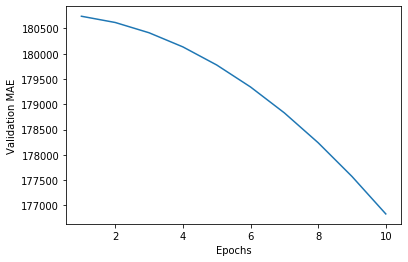

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Second time to run model:
After adding encoded categorical variables to the dataset

In [ ]:
average_mae_history

[180739.16,
 180611.06,
 180400.83,
 180110.56,
 179740.1,
 179288.31,
 178757.42,
 178144.34,
 177454.0,
 176683.17]

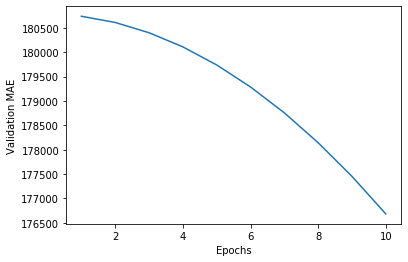

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### a. number of layers and sizes


added one layer (4 layers total)

In [ ]:
average_mae_history

[179484.69,
 171534.48,
 151998.55,
 125662.234,
 118494.555,
 118840.836,
 119013.13,
 119007.484,
 119098.62,
 119083.92]

Changed layer thickenss to input size, second layer to half, third layer to one fourth

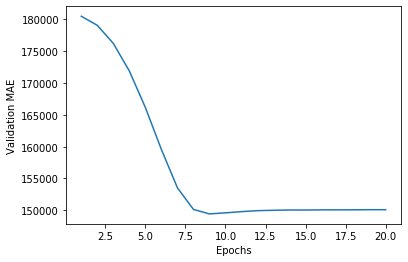

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### b. use of optimizers


* Change optimizer to Adam and 5 layers
* shuffeling the order of houses
* dropping vraibles that are not being used

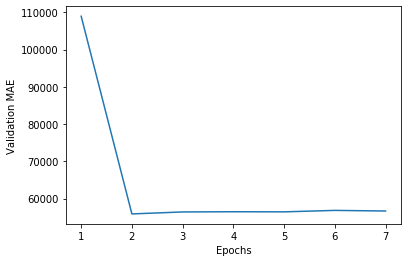

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Step five: Test dataset results

Final test

In [ ]:
all_scores = []
all_mae_histories = []

# hyper parameters
k = 4
num_val_samples = len(test_data) // k
num_epochs = 20
epsilon = 0.0001

#shuffel the order of the elements
np.random.shuffle(train_data)

# setting up the loop for k-fold
for i in range(k):
    print('processing fold #', i)
    
    # reserving validation dataset
    val_data = test_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = test_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # reserving training dataset
    partial_train_data = np.concatenate(
        [test_data[:i * num_val_samples],
         test_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [test_targets[:i * num_val_samples],
         test_targets[(i + 1) * num_val_samples:]],       axis=0)
    
    #normalization
    train_mean = np.nanmean(partial_train_data, axis=0)
    train_std = np.nanstd(partial_train_data, axis=0)
    partial_train_data -= train_mean
    partial_train_data /= train_std+ epsilon
    
    val_mean = np.nanmean(val_data, axis=0)
    val_std = np.nanstd(val_data,axis=0)
    val_data -= val_mean
    val_data /= val_std + epsilon
    
    
    # Build the Keras model (already compiled)
    model = make_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    # store scores
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
Train on 321 samples, validate on 106 samples
Epoch 1/20
321/321 [==============================] - 2s 6ms/sample - loss: 43238370727.8754 - mae: 187654.5469 - val_loss: 39159776209.6604 - val_mae: 183614.0156
Epoch 2/20
321/321 [==============================] - 1s 4ms/sample - loss: 42774276676.1869 - mae: 186448.5781 - val_loss: 38021776125.0566 - val_mae: 180488.6250
Epoch 3/20
321/321 [==============================] - 1s 4ms/sample - loss: 40309714629.3832 - mae: 179522.4844 - val_loss: 34014554171.3184 - val_mae: 169061.0000
Epoch 4/20
321/321 [==============================] - 1s 4ms/sample - loss: 34129292066.6916 - mae: 160929.8438 - val_loss: 26000365203.3208 - val_mae: 143890.8438
Epoch 5/20
321/321 [==============================] - 1s 4ms/sample - loss: 24584456089.9805 - mae: 129023.8984 - val_loss: 16117888701.2075 - val_mae: 105065.0859
Epoch 6/20
321/321 [==============================] - 1s 4ms/sample - loss: 15410309074.9668 - mae: 90723.6484 - v

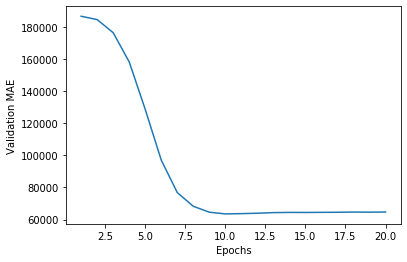

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()